# RNN Classifier

In [3]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import SpatialDropout1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
output_dir = '/Users/trinakarmakar/anaconda2/model_output/LSTM/'

#training hyperparameters
epochs = 4
batch_size = 128

#vector space embedding hyper parameters 
n_dim = 64 
n_unique_words = 10000
max_review_length = 100
pad_type = trunc_type = 'pre' #pad shorter reviews or truncate longer reviews 
drop_emb = 0.2
n_lstm = 256
drop_lstm = 0.2

In [5]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

In [6]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating = trunc_type)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating = trunc_type)

In [7]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_emb))
model.add(LSTM(n_lstm, dropout=drop_lstm))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"weights.{epoch:02d}.hdf5")

In [11]:
model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs, verbose=1, validation_data=(X_valid, y_valid), 
          callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 293s 12ms/step - loss: 0.5254 - acc: 0.7208 - val_loss: 0.3569 - val_acc: 0.8412

In [12]:
model.load_weights(output_dir+'weights.01.hdf5')

In [13]:
y_hat = model.predict_proba(X_valid)

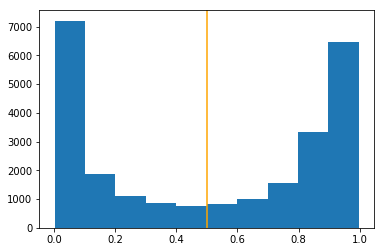

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [16]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'92.35'

In [17]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=["y_hat", 'y'])

In [18]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10) #predicted highly negative but in reality it is postive review

,y_hat,y
112,0.914511,0
152,0.915758,0
247,0.927703,0
299,0.914461,0
342,0.947902,0
376,0.910339,0
386,0.934206,0
558,0.916818,0
680,0.947698,0
693,0.940087,0


In [19]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10) #predicted positive but in reality it is negative review

,y_hat,y
227,0.092615,1
300,0.065444,1
325,0.084402,1
333,0.054272,1
355,0.094219,1
667,0.082794,1
841,0.069342,1
988,0.065086,1
1198,0.092376,1
1229,0.066947,1
